## COVID-19 data analysis

<img src=coronavirus-DNA-720.png  width="1200" >

In [1]:
#reload library if modified
%load_ext autoreload
%autoreload 2

In [2]:
#see online at https://covid19-jyy3.onrender.com
from util import *
#libraries
import pandas as pd
import seaborn as sns 
import matplotlib.pyplot as plt
import os
import numpy as np
from scipy.stats import pearsonr
from sklearn.metrics import mean_squared_error
import datetime
import matplotlib.dates as mdates
from matplotlib.dates import DateFormatter
from matplotlib.dates import date2num
import gc
plt.style.use('ggplot')

# Load Global Dataset

In [5]:
#Download world dataset
!curl https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_deaths_global.csv -o deaths_global.csv 
allDf = pd.read_csv('deaths_global.csv')
print('last data:',allDf.columns[-1])
allDf.tail()

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 66458  100 66458    0     0  95623      0 --:--:-- --:--:-- --:--:-- 95760
last data: 4/29/20


,Province/State,Country/Region,Lat,Long,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,...,4/20/20,4/21/20,4/22/20,4/23/20,4/24/20,4/25/20,4/26/20,4/27/20,4/28/20,4/29/20
259,Saint Pierre and Miquelon,France,46.885200,-56.315900,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
260,NaN,South Sudan,6.877000,31.307000,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
261,NaN,Western Sahara,24.215500,-12.885800,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
262,NaN,Sao Tome and Principe,0.186360,6.613081,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
263,NaN,Yemen,15.552727,48.516388,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [6]:
#keep Italian repository update
!git pull https://github.com/pcm-dpc/COVID-19.git master --no-edit

From https://github.com/pcm-dpc/COVID-19
 * branch            master     -> FETCH_HEAD
Already up-to-date.


# Load National Dataset

In [7]:
df = pd.read_csv(os.path.join('dati-andamento-nazionale',
                               'dpc-covid19-ita-andamento-nazionale.csv'))
df.data = pd.to_datetime(df.data)
#assuming terapia_intensiva (intensive care) and deceduti (deaths)
#are cumulative. It is not specified in the dataset.
#Computing Daily new cases
df['ricoverati_con_sintomi_change']=df['ricoverati_con_sintomi']-df['ricoverati_con_sintomi'].shift(1)
df['terapia_intensiva_change']=df['terapia_intensiva']-df['terapia_intensiva'].shift(1)
df['deceduti_daily']=df['deceduti']-df['deceduti'].shift(1)


#The number of deaths over the number 
#of new cases admitted in intensive care (daily)
df['not_admitted_ratio'] = df['deceduti_daily']/(df['terapia_intensiva_change'])
#The number of deaths minus the number 
#of new cases admitted in intensive care (daily)
df['not_admitted'] = df['deceduti_daily']-(df['terapia_intensiva_change'])

#remove unused
df.drop(['stato'],axis=1,inplace=True)
df.drop(['data'],axis=1).tail()

#compute log of selected columns
cols = ['nuovi_positivi',#new positive case now
          'deceduti_daily',#today deaths
          'terapia_intensiva',#Intensive care
          'deceduti'#deaths
         ]
for c in cols:
    
    df[c+'_log']=np.log10(df[c])
df[cols+['deceduti_daily_log']].head(5)

,nuovi_positivi,deceduti_daily,terapia_intensiva,deceduti,deceduti_daily_log
0,221,NaN,26,7,NaN
1,93,3.0,35,10,0.477121
2,78,2.0,36,12,0.301030
3,250,5.0,56,17,0.698970
4,238,4.0,64,21,0.602060


# Fig1 
How the death rate changes before and after the introduction of social distancing mesures in Italy?

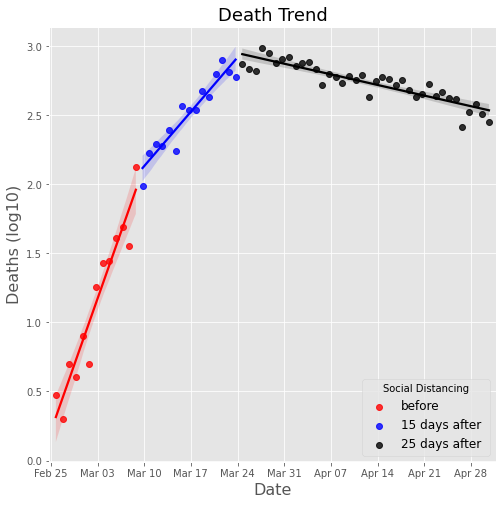

In [8]:
make_fig1(df)

# Fig2 
How many more people die in Italy respect to the people admitted in intensive care?

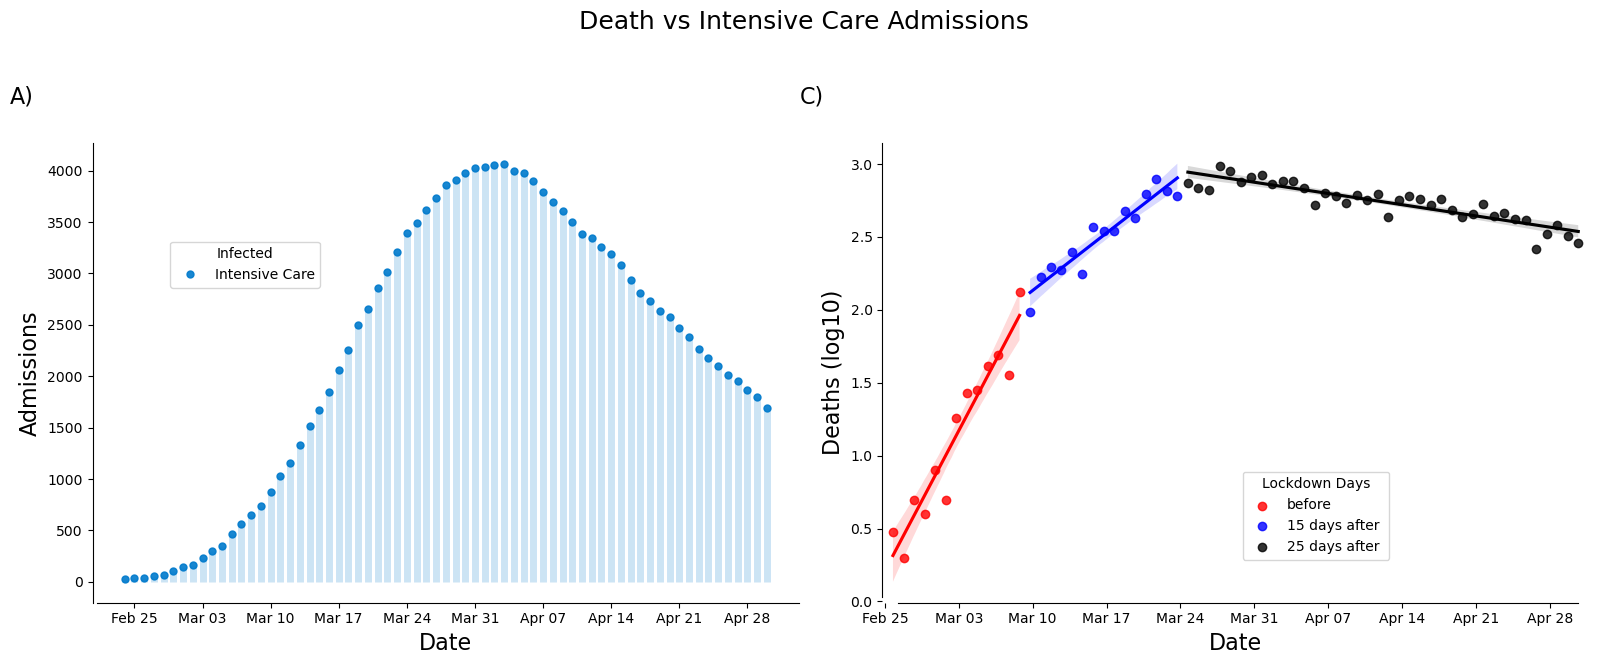

In [9]:
make_fig2(df)

# Fig3
How UK deaths compare to Italy and Spain

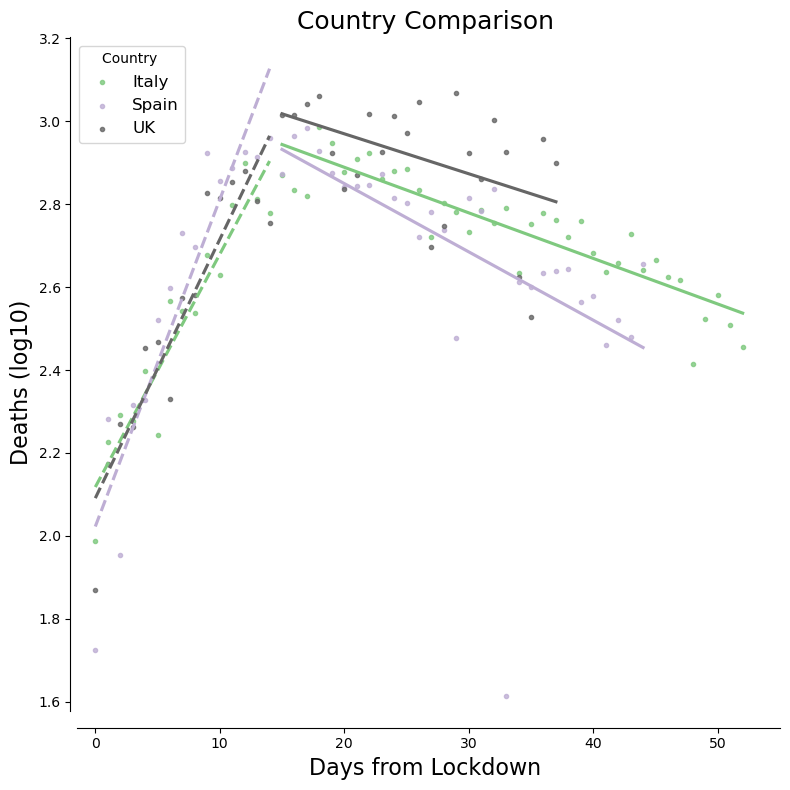

In [10]:
make_fig3(df,allDf)

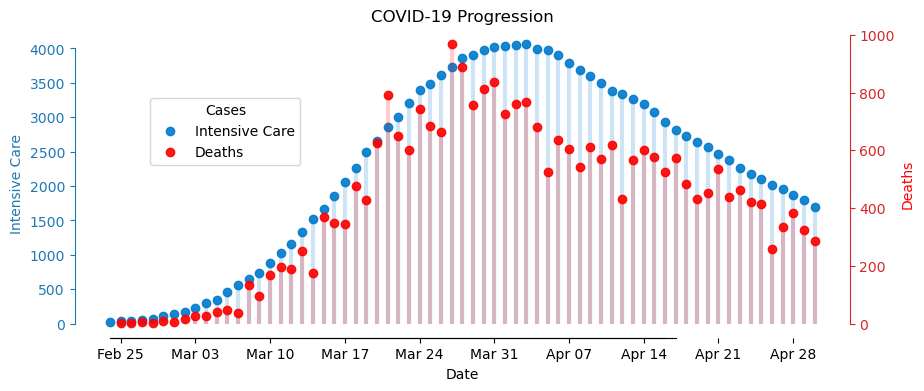

In [11]:
fig,ax=plt.subplots(figsize=(10,4))

ax = lollipop_plot(df, 
                   ax, date_col='data',
                   value_col='terapia_intensiva',
                   label='Intensive Care',
                  markersize=6,
                  linewidth=3)

axt=ax.twinx()

axt = lollipop_plot(df, axt, date_col='data',
                       value_col='deceduti_daily',label='Deaths',
                  color='red',do_despine=False,
                    do_format_date=True,
                   markersize=6,
                  linewidth=3)
axt.set_ylabel('Deaths',color='red')
ax.set_xlabel('Date')
#ax.legend(loc=2, bbox_to_anchor=(0.1, 0.8), title='Infected')
#axt.legend(loc=2, bbox_to_anchor=(0.1, 0.8), title='Infected')
plt.style.use('default')
lines,labels=merge_legends([ax,axt])
ax.legend(lines, labels, loc=0,
          title='Cases', bbox_to_anchor=(0.3, 0.8))

axt.spines['right'].set_bounds(0, 1000)
ax.spines['right'].set_color('none')

axt.spines['right'].set_color('#d62728')
axt.tick_params(axis='y', colors='#d62728')

axt.spines['left'].set_color('none')
axt.spines['top'].set_color('none')
ax.spines['top'].set_color('none')
ax.spines['left'].set_bounds(0, 4000)

ax.spines['left'].set_color('#1f77b4')
ax.tick_params(axis='y', colors='#1f77b4')
ax.set_ylabel('Intensive Care',color='#1f77b4')

ax.spines['bottom'].set_bounds(737476.4+2.6, 737533.6-2.6)
axt.spines['bottom'].set_bounds(737476.4+2.6, 737533.6-1.6)
plt.title('COVID-19 Progression')
plt.show()

In [12]:
#from matplotlib.colors import ListedColormap
#sns.color_palette("tab10").as_hex()


In [13]:
!jupyter nbconvert --to html_toc DataVis.ipynb

[NbConvertApp] Converting notebook DataVis.ipynb to html_toc
[NbConvertApp] Support files will be in DataVis_files/
[NbConvertApp] Making directory DataVis_files
[NbConvertApp] Making directory DataVis_files
[NbConvertApp] Making directory DataVis_files
[NbConvertApp] Making directory DataVis_files
[NbConvertApp] Writing 307225 bytes to DataVis.html


In [228]:
!git add DataVis*
!git add util.py
!git add Fig**
!git add -u
!git commit -m 'move cells'
!git push -u origin master

[master 0d19301] move cells
 10 files changed, 232 insertions(+), 644 deletions(-)
 rewrite DataVis.ipynb (100%)
 rewrite DataVis_files/DataVis_11_0.png (98%)
 rewrite DataVis_files/DataVis_13_0.png (98%)
 rewrite DataVis_files/DataVis_14_0.png (99%)
 rewrite DataVis_files/DataVis_9_0.png (99%)
 rewrite Fig1.png (99%)
 rewrite Fig2.png (98%)
 rewrite Fig3.png (98%)
Counting objects: 39, done.
Delta compression using up to 8 threads.
Compressing objects: 100% (38/38), done.
Writing objects: 100% (39/39), 436.51 KiB | 0 bytes/s, done.
Total 39 (delta 14), reused 0 (delta 0)
remote: Resolving deltas: 100% (14/14), completed with 3 local objects.
To https://github.com/mtinti/COVID-19.git
   6082dd4..0d19301  master -> master
Branch master set up to track remote branch master from origin.
